#### Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd '/content/drive/MyDrive/FYP/Project/Neural network'

/content/drive/MyDrive/FYP/Project/Neural network


### Dataset Loading

In [ ]:
import pandas as pd
import numpy as np
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt

from torch import nn
import torch.optim as optim
from torchinfo import summary

In [ ]:
df = pd.read_csv('data_preprocessed.csv')

In [ ]:
# split train test set
from sklearn.model_selection import train_test_split

y = df[df.columns[-1]]
X = df.drop(df.columns[-1], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

#### Helper function

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def evaluate_acc(net, dataloader):
  net.eval()
  inputs, labels = next(iter(dataloader))

  inputs = inputs.to(device)
  labels = labels.to(device)

  with torch.no_grad():
    running_corrects = 0
    outputs = net(inputs)
    predicted = outputs.ravel() >= 0.5
    running_corrects += (labels == predicted).double().sum()

  acc = running_corrects/len(labels)

  return acc

In [ ]:
# train function

def train(net, trainloader, device, num_epochs=15, lr=0.1, momentum=0.9):
  loss_iterations = int(np.ceil(len(trainloader)/3))

  # transfer to model to GPU
  net = net.to(device)

  # optimizer
  optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)

  # set to training mode
  # net.train()

  # variables
  best_loss = np.inf
  saturated_count = 0

  history = {'iter' : [], 'cost': [], 'acc_train' : [], 'acc_val' : [] }

  # train network
  for e in range(num_epochs):

    net.train()
    running_loss = 0
    running_count = 0

    epoch_loss = 0
    epoch_count = 0

    for i, (inputs, labels) in enumerate(trainloader):

      labels = labels.reshape(-1, 1).float()

      # clear gradient to zero
      optimizer.zero_grad()

      # transfer data to GPU
      inputs = inputs.to(device)
      labels = labels.to(device)

      # forward prop
      outs = net(inputs)

      # compute loss
      loss = F.binary_cross_entropy(outs, labels)

      # backprop
      loss.backward()

      # update params
      optimizer.step()

      # get the loss of training
      running_loss += loss.item()
      running_count += 1

      epoch_loss += loss.item()
      epoch_count += 1

      # display the averaged loss value
      if i % loss_iterations == loss_iterations-1 or i == len(trainloader) - 1:
        train_loss = running_loss / running_count
        running_loss = 0.
        running_count = 0.
        print(f'[Epoch {e+1:2d} Iter {i+1:5d}/{len(trainloader)}]: train_loss = {train_loss:.4f}')

    # store cost

    history['cost'].append(epoch_loss/epoch_count)
    epoch_loss = 0
    epoch_count = 0

    # Compute the training and validation accuracy
    history['iter'].append(e)

    acc_train = evaluate_acc(net, trainloader)
    history['acc_train'].append(acc_train)

    acc_val = evaluate_acc(net, testloader)
    history['acc_val'].append(acc_val)

  print("Training completed.")
  return history


In [ ]:
# evaluate function

def evaluate(net, dataloader, device):
  # set to eval mode
  net.eval()

  running_corrects = 0

  # repeat for all batch data in test set
  for inputs, targets in dataloader:
    inputs = inputs.to(device)
    targets = targets.to(device)

    # disable gradient computation
    with torch.no_grad():
      outputs = net(inputs)
      predicted = outputs.ravel() >= 0.5
      running_corrects += (targets == predicted).double().sum()

    acc = running_corrects/len(dataloader.dataset)

  print(f'{acc = :.4f}')

#### Dataloader

In [ ]:
from torch.utils.data import DataLoader, Dataset

In [ ]:
class MyDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    # Get data and label from your dataframe
    data = torch.tensor(self.data.iloc[idx].to_numpy(), requires_grad=True, dtype=torch.float32)# Replace with your feature columns
    label = torch.tensor(self.labels.iloc[idx], requires_grad=True, dtype=torch.float32)  # Replace with your label column

    return data, label


In [ ]:
trainset = MyDataset(X_train, y_train)
testset = MyDataset(X_test, y_test)

In [ ]:
trainloader = DataLoader(trainset, 128, True)
testloader = DataLoader(testset, 128, True)

#### Neural Network setup

In [ ]:
!pip install torchinfo

In [ ]:
class Net(nn.Module):
    def __init__(self, layer_size):
        super().__init__()
        # layers here
        self.layers = nn.ModuleList()

        self.layers.append(nn.Linear(in_features=51, out_features=layer_size[0]))

        for i in range(1, len(layer_size)):
          self.layers.append(nn.Linear(layer_size[i-1], layer_size[i]))

    def forward(self, x):

        # forward prop
        for layer in self.layers[:-1]:
          x = torch.relu(layer(x))

        x = torch.sigmoid(self.layers[-1](x))

        return x

In [ ]:
net1 = Net((200, 300, 100, 70, 1))

In [ ]:
col_names = ["input_size", "output_size", "num_params", "mult_adds", "trainable"]
summary(net1, input_size=(32, 51), col_names=col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Mult-Adds                 Trainable
Net                                      [32, 51]                  [32, 1]                   --                        --                        True
├─ModuleList: 1-1                        --                        --                        --                        --                        True
│    └─Linear: 2-1                       [32, 51]                  [32, 200]                 10,400                    332,800                   True
│    └─Linear: 2-2                       [32, 200]                 [32, 300]                 60,300                    1,929,600                 True
│    └─Linear: 2-3                       [32, 300]                 [32, 100]                 30,100                    963,200                   True
│    └─Linear: 2-4                       [32, 100]                 [32, 70]                  7,

In [ ]:
history = train(net1, trainloader, device, num_epochs=24, lr=0.005)

[Epoch  1 Iter    20/58]: train_loss = 0.6800
[Epoch  1 Iter    40/58]: train_loss = 0.6684
[Epoch  1 Iter    58/58]: train_loss = 0.6613
[Epoch  2 Iter    20/58]: train_loss = 0.6401
[Epoch  2 Iter    40/58]: train_loss = 0.6215
[Epoch  2 Iter    58/58]: train_loss = 0.5579
[Epoch  3 Iter    20/58]: train_loss = 0.4400
[Epoch  3 Iter    40/58]: train_loss = 0.3215
[Epoch  3 Iter    58/58]: train_loss = 0.3021
[Epoch  4 Iter    20/58]: train_loss = 0.2752
[Epoch  4 Iter    40/58]: train_loss = 0.2571
[Epoch  4 Iter    58/58]: train_loss = 0.3163
[Epoch  5 Iter    20/58]: train_loss = 0.2863
[Epoch  5 Iter    40/58]: train_loss = 0.2645
[Epoch  5 Iter    58/58]: train_loss = 0.2463
[Epoch  6 Iter    20/58]: train_loss = 0.2479
[Epoch  6 Iter    40/58]: train_loss = 0.2399
[Epoch  6 Iter    58/58]: train_loss = 0.2433
[Epoch  7 Iter    20/58]: train_loss = 0.2399
[Epoch  7 Iter    40/58]: train_loss = 0.2475
[Epoch  7 Iter    58/58]: train_loss = 0.2287
[Epoch  8 Iter    20/58]: train_lo

In [ ]:
evaluate(net1, testloader, device)

acc = 0.8588


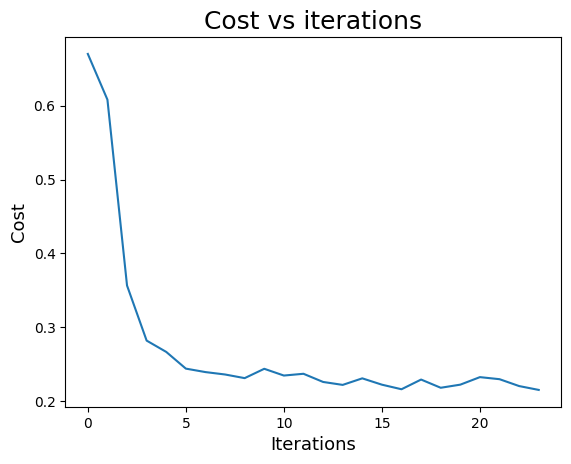

In [ ]:
def plot_history_cost(history):
    plt.plot(history['iter'], history['cost'], label='cost')
    plt.ylabel('Cost', fontsize=13)
    plt.xlabel('Iterations', fontsize=13)
    plt.title('Cost vs iterations', fontsize=18)
    plt.show()

plot_history_cost(history)

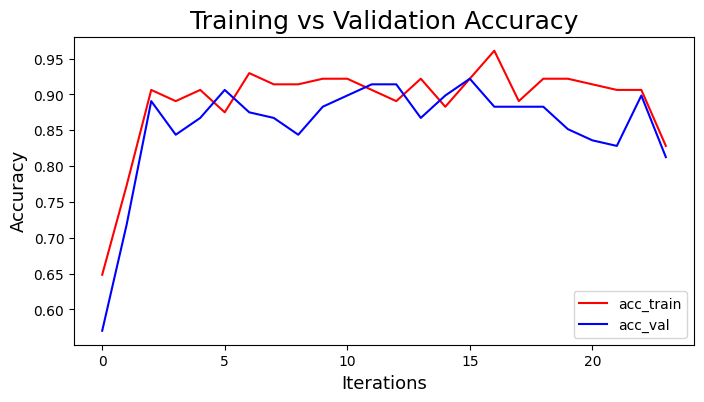

In [ ]:
def plot_history_acc(history):
    plt.figure(figsize=(8, 4))
    plt.plot(history['iter'], history['acc_train'], color='red', label='acc_train')
    plt.plot(history['iter'], history['acc_val'], color='blue', label='acc_val')
    plt.ylabel('Accuracy', fontsize=13)
    plt.xlabel('Iterations', fontsize=13)
    plt.title('Training vs Validation Accuracy', fontsize=18)
    plt.legend()
    plt.show()

plot_history_acc(history)

In [ ]:
net1.eval()
x_eval, y_eval = next(iter(testloader))
correct = 0
yhat = net1(x_eval)

ypred = yhat.ravel() >= 0.5

correct = (y_eval == ypred).double().sum()
acc = correct / len(y_eval)
print(acc)

tensor(0.8359, dtype=torch.float64)


In [ ]:
X_test_np = X_test.iloc[1].to_numpy()
y_test_np = y_test.iloc[1]

input = torch.tensor(X_test_np, dtype=torch.float32)
output = torch.tensor(y_test_np, dtype=torch.float32)

y_pred = net1(input)
y_pred = y_pred.ravel() >= 0.5
print(f'output: {output}, y_pred: {y_pred.item()}')

output: 0.0, y_pred: False
